# SAE Feature & Activation Analysis

Этот ноутбук анализирует сохранённые чанки с активациями SAE (и опционально hidden states LLM), которые получены скриптом `get_activations.py`.

## 1) Setup

In [ ]:
import os
import glob
import json
import random
import numpy as np
import torch

DUMP_DIR = "/Users/dekovaleva/PythonProjects/security_sae/sae_feats_layer20"
OUTPUT_DIR = "activation_report"
RANDOM_SEED = 0
SAMPLE_SIZE = 20000
HIST_BINS = 100
DPI = 200

meta_path = os.path.join(DUMP_DIR, "meta.json")
meta = json.load(open(meta_path, "r", encoding="utf-8"))
meta


{'MODEL_ID': 'Qwen/Qwen3-4B',
 'CSV_PATH': '/Users/dekovaleva/PythonProjects/security_sae/dataset/dataset.csv',
 'SAE_CKPT_PATH': '/Users/dekovaleva/PythonProjects/security_sae/activations/ckpt_epoch_15.pt',
 'TEXT_COL': 'prompt',
 'MAX_LENGTH': 512,
 'BATCH_SIZE': 2,
 'LAYER_IDX': 20,
 'NUM_LAYERS': 36,
 'D_MODEL': 2560,
 'SAE_D_IN': 2560,
 'SAE_D_FEAT': 20480,
 'TOKEN_SUBSAMPLE_P': 1.0,
 'LLM_DTYPE': 'torch.bfloat16',
 'SAE_DTYPE': 'torch.bfloat16'}

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image, display

plt.style.use("dark_background")
plt.rcParams.update({
    "figure.facecolor": "#111111",
    "axes.facecolor": "#111111",
    "savefig.facecolor": "#111111",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "grid.color": "white",
})

OUT_DIR = Path(OUTPUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)


def savefig(name: str, dpi: int = None, **kwargs):
    """Сохраняет текущую фигуру в OUTPUT_DIR с тёмным фоном и bbox_inches='tight'."""
    if dpi is None:
        dpi = DPI
    path = OUT_DIR / name
    plt.savefig(
        path,
        dpi=dpi,
        facecolor=plt.gcf().get_facecolor(),
        bbox_inches="tight",
        **kwargs
    )
    plt.close()
    print(f"Saved: {path}")
    return path


def show_img(name: str, width: int = 900):
    """Отображает сохранённый PNG в ноутбуке."""
    path = OUT_DIR / name
    if not path.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    display(Image(str(path), width=width))

## 2) Locate chunks

In [ ]:
pt_files = sorted(glob.glob(os.path.join(DUMP_DIR, "sae_feats_layer*_chunk*.pt")))

if not pt_files:
    raise ValueError(f"No chunk files found in {DUMP_DIR}")

print(f"Found {len(pt_files)} chunks")

obj0 = torch.load(pt_files[0], map_location="cpu")
if "sae_feats" not in obj0:
    raise ValueError(f"Expected 'sae_feats' key in chunk file. Got keys: {list(obj0.keys())}")

sae_feats = obj0["sae_feats"]
assert isinstance(sae_feats, torch.Tensor), f"sae_feats must be Tensor, got {type(sae_feats)}"
assert len(sae_feats.shape) == 2, f"sae_feats must be 2D [N, M], got shape {sae_feats.shape}"

print(f"sae_feats shape: {tuple(sae_feats.shape)}, dtype: {sae_feats.dtype}")
if "llm_acts" in obj0:
    print(f"llm_acts shape: {tuple(obj0['llm_acts'].shape)}, dtype: {obj0['llm_acts'].dtype}")


num chunks: 261
first: /Users/dekovaleva/PythonProjects/security_sae/sae_feats_layer20/sae_feats_layer20_chunk00000.pt
last : /Users/dekovaleva/PythonProjects/security_sae/sae_feats_layer20/sae_feats_layer20_chunk00260.pt
keys: dict_keys(['sae_feats', 'total_tokens_so_far'])
sae_feats: (2513, 20480) torch.bfloat16


## 3) Streamed stats over all tokens (без OOM)

Считаем по всем токенам:
- `firing_rate`: доля токенов с `a>0`
- `mean_all`: среднее по всем токенам
- `mean_when_active`: среднее по активным (`a>0`)
- `max_all`: максимум
- `avg_active_feats_per_token`: среднее число активных фич на токен


In [ ]:
from tqdm import tqdm

M = int(meta.get("SAE_D_FEAT", obj0["sae_feats"].shape[1]))

count_tokens = 0
sum_all = torch.zeros(M, dtype=torch.float64)
sum_active = torch.zeros(M, dtype=torch.float64)
active_count = torch.zeros(M, dtype=torch.int64)
max_all = torch.zeros(M, dtype=torch.float32)
total_active_entries = 0

for f in tqdm(pt_files):
    obj = torch.load(f, map_location="cpu")
    if "sae_feats" not in obj:
        raise ValueError(f"Missing 'sae_feats' in {f}")
    a = obj["sae_feats"].float()
    assert len(a.shape) == 2 and a.shape[1] == M, \
        f"Expected shape [N, {M}], got {a.shape}"

    count_tokens += a.shape[0]
    sum_all += a.sum(dim=0).double()
    is_active = a > 0
    active_count += is_active.sum(dim=0).to(torch.int64)
    sum_active += (a * is_active).sum(dim=0).double()
    max_all = torch.maximum(max_all, a.max(dim=0).values)
    total_active_entries += int(is_active.sum().item())

mean_all = (sum_all / max(count_tokens, 1)).float()
firing_rate = (active_count.float() / max(count_tokens, 1))
mean_when_active = (sum_active / active_count.clamp_min(1).double()).float()
avg_active_feats_per_token = total_active_entries / max(count_tokens, 1)

print(f"Total tokens: {count_tokens}")
print(f"Avg active feats per token: {avg_active_feats_per_token:.2f}")
print(f"Mean firing rate: {firing_rate.mean().item():.4f}")
print(f"Fraction never-active: {(active_count == 0).float().mean().item():.4f}")


100%|██████████| 261/261 [00:35<00:00,  7.28it/s]

tokens: 690475
avg active feats per token: 11860.28835946269
mean firing rate: 0.5791156888008118
fraction never-active: 0.0


## 4) Визуализации: firing rate / sparsity / топы

Saved: activation_report/01_firing_rate_hist.png


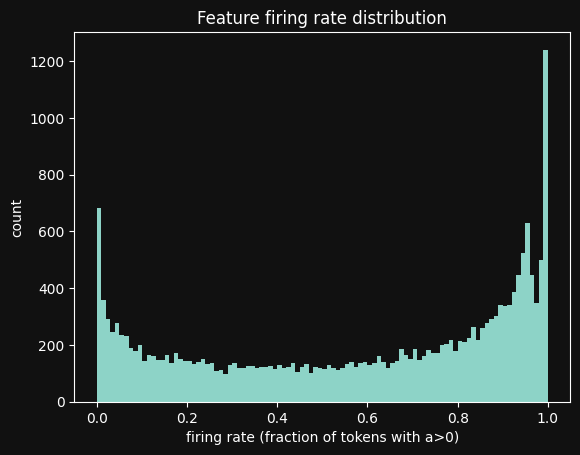

Saved: activation_report/02_log10_firing_rate_hist.png


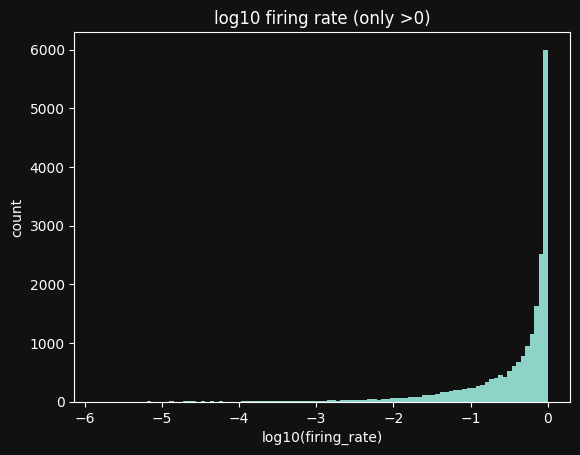

Top-10 firing rate idx+value:
14600 1.0
398 1.0
14104 1.0
133 1.0
13525 1.0
10251 1.0
7362 1.0
9744 1.0
16750 1.0
15255 0.99999857

Top-10 max activation idx+value:
9816 1040.0
9072 1020.0
10207 1016.0
2479 1012.0
15853 996.0
2962 988.0
8245 984.0
2067 984.0
19901 980.0
973 976.0

Top-10 mean_when_active idx+value:
11175 197.23547
16011 166.38745
14286 164.98067
19969 159.35245
15742 156.03734
7270 149.75673
6385 147.27222
18374 143.98218
2862 142.90416
14922 142.61057
Saved: activation_report/03_top30_firing_rate.png


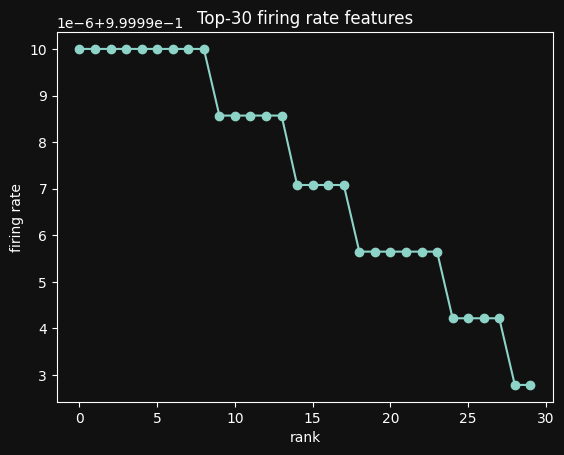

Saved: activation_report/04_top30_max_activation.png


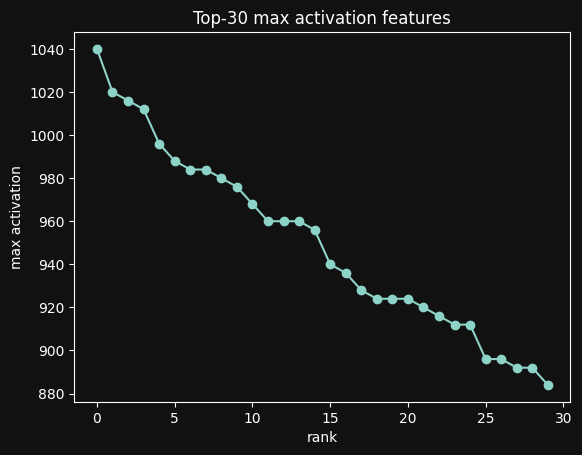

Saved: activation_report/05_top30_mean_when_active.png


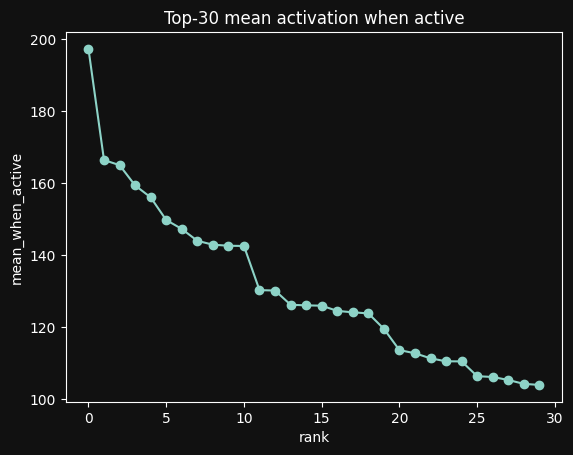

In [ ]:
fr = firing_rate.numpy()
mwa = mean_when_active.numpy()
mx = max_all.numpy()


def topk_idx(x, k=30):
    return np.argsort(-np.asarray(x))[:k]


plt.figure()
plt.hist(fr, bins=HIST_BINS)
plt.title("Feature firing rate distribution")
plt.xlabel("firing rate (fraction of tokens with a>0)")
plt.ylabel("count")
savefig("01_firing_rate_hist.png")

plt.figure()
plt.hist(np.log10(fr[fr > 0]), bins=HIST_BINS)
plt.title("log10 firing rate (only >0)")
plt.xlabel("log10(firing_rate)")
plt.ylabel("count")
savefig("02_log10_firing_rate_hist.png")

top_fr = topk_idx(fr, 30)
top_mx = topk_idx(mx, 30)
top_mwa = topk_idx(mwa, 30)

print("Top-10 firing rate:")
for i in top_fr[:10]:
    print(f"  idx={i}, value={fr[i]:.6f}")

print("\nTop-10 max activation:")
for i in top_mx[:10]:
    print(f"  idx={i}, value={mx[i]:.2f}")

print("\nTop-10 mean_when_active:")
for i in top_mwa[:10]:
    print(f"  idx={i}, value={mwa[i]:.2f}")

plt.figure()
plt.plot(fr[top_fr], marker="o")
plt.title("Top-30 firing rate features")
plt.xlabel("rank")
plt.ylabel("firing rate")
savefig("03_top30_firing_rate.png")

plt.figure()
plt.plot(mx[top_mx], marker="o")
plt.title("Top-30 max activation features")
plt.xlabel("rank")
plt.ylabel("max activation")
savefig("04_top30_max_activation.png")

plt.figure()
plt.plot(mwa[top_mwa], marker="o")
plt.title("Top-30 mean activation when active")
plt.xlabel("rank")
plt.ylabel("mean_when_active")
savefig("05_top30_mean_when_active.png")

## 5) Sparsity: сколько фич активны на токен (на подвыборке)

Полный подсчёт по всем токенам может быть тяжёлым, поэтому берём подвыборку токенов `S`.


sampled X: (13676, 20480)
Saved: activation_report/06_active_features_per_token_hist.png


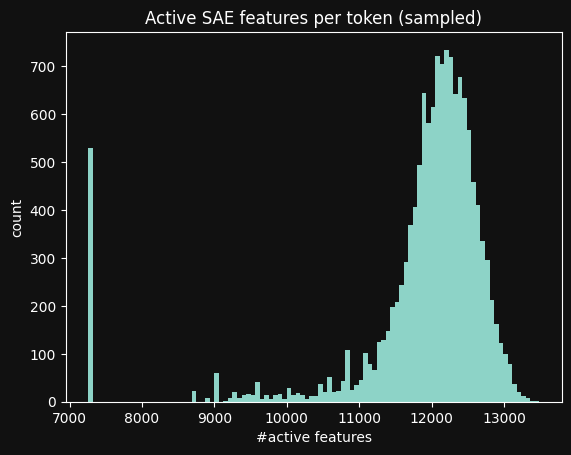

mean: 11863.602076630594
median: 12123.0
p95: 12819.0


In [ ]:
rng = random.Random(RANDOM_SEED)
samples = []
left = SAMPLE_SIZE

for f in pt_files:
    if left <= 0:
        break
    obj = torch.load(f, map_location="cpu")
    if "sae_feats" not in obj:
        continue
    a = obj["sae_feats"].float()
    n = a.shape[0]
    if n == 0:
        continue

    take = min(left, max(1, n // 50))
    take = min(take, n)
    idx = rng.sample(range(n), k=take)
    samples.append(a[idx])
    left -= take

X = torch.cat(samples, dim=0)
print(f"Sampled X shape: {tuple(X.shape)}")

active_counts = (X > 0).sum(dim=1).numpy()

plt.figure()
plt.hist(active_counts, bins=HIST_BINS)
plt.title("Active SAE features per token (sampled)")
plt.xlabel("#active features")
plt.ylabel("count")
savefig("06_active_features_per_token_hist.png")

print(f"Mean: {active_counts.mean():.2f}")
print(f"Median: {np.median(active_counts):.2f}")
print(f"p95: {np.percentile(active_counts, 95):.2f}")


In [ ]:
x = X.numpy()
print(f"X shape: {X.shape}")
print(f"min/median/mean/max: {x.min():.4f} / {np.median(x):.4f} / {x.mean():.4f} / {x.max():.2f}")
print(f"p1/p5/p50/p95/p99: {np.percentile(x, [1, 5, 50, 95, 99])}")

for eps in [0.0, 1e-4, 1e-3, 1e-2, 1e-1]:
    frac = (X > eps).float().mean().item()
    act_tok = (X > eps).sum(dim=1).float().mean().item()
    print(f"eps={eps:>6}: frac>eps={frac:.4f}, active_per_token_mean={act_tok:.1f}")

X shape: torch.Size([13676, 20480])
min/median/mean/max: 0.0 0.234375 2.2335546 780.0
p1/p5/p50/p95/p99: [ 0.        0.        0.234375  2.25     55.5     ]
eps=   0.0: frac>eps=0.5793, active_per_token_mean=11863.6
eps=0.0001: frac>eps=0.5793, active_per_token_mean=11863.3
eps= 0.001: frac>eps=0.5790, active_per_token_mean=11856.9
eps=  0.01: frac>eps=0.5760, active_per_token_mean=11796.2
eps=   0.1: frac>eps=0.5459, active_per_token_mean=11180.0


In [ ]:
l0 = (X > 0).sum(dim=1).numpy()
print(f"L0 mean: {l0.mean():.2f}")
print(f"L0 median: {np.median(l0):.2f}")
print(f"L0 p95: {np.percentile(l0, 95):.2f}")
print(f"L0 p99: {np.percentile(l0, 99):.2f}")

L0 mean: 11863.602076630594
L0 median: 12123.0
L0 p95: 12819.0
L0 p99: 13062.0


## 6) PCA (по подвыборке токенов)

PCA даёт быстрый взгляд на структуру фич.


Saved: activation_report/07_pca_scatter.png


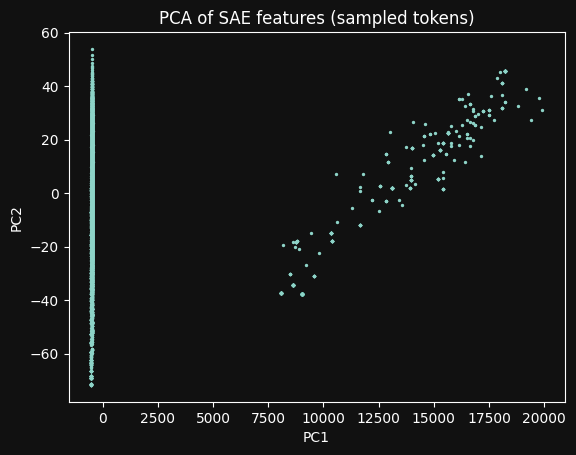

explained variance ratio: [9.9932253e-01 6.3564134e-05]


In [ ]:
from sklearn.decomposition import PCA

X_np = X.numpy()
pca = PCA(n_components=2, random_state=RANDOM_SEED)
Z = pca.fit_transform(X_np)

plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], s=2)
plt.title("PCA of SAE features (sampled tokens)")
plt.xlabel("PC1")
plt.ylabel("PC2")
savefig("07_pca_scatter.png")

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")



## 8) Сохраняем метрики

Сохраняем `firing_rate`, `mean_all`, `mean_when_active`, `max_all` как `.npz`.


In [ ]:
out_npz = os.path.join(DUMP_DIR, "feature_stats.npz")
np.savez(
    out_npz,
    firing_rate=firing_rate.numpy(),
    mean_all=mean_all.numpy(),
    mean_when_active=mean_when_active.numpy(),
    max_all=max_all.numpy(),
    active_count=active_count.numpy(),
    token_count=np.array([count_tokens], dtype=np.int64),
)
print(f"Saved: {out_npz}")


saved: /Users/dekovaleva/PythonProjects/security_sae/sae_feats_layer20/feature_stats.npz
